In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv, Linear, GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader
from sklearn.metrics import balanced_accuracy_score,f1_score,roc_auc_score, precision_score, recall_score
import torch.optim as optim
import pandas as pd
import os
import numpy as np
import time
import matplotlib.pyplot as plt

start = time.time()


/Users/npatel/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load nodes and edges CSV files
root_path = '/Users/npatel/Library/CloudStorage/Dropbox/Nish/Rutgers MSDS/3_2023F/Massive Data Storage/Project/NN Project 2/'
# root_path = '/common/users/shared/cs543_group4/graph_csvs'
nodes_df = pd.read_csv(os.path.join(root_path, 'nodes_small.csv'), dtype={'unique_id_int': int, 'bank':int, 'is_laundering':int, 'transactions_from':int,'transactions_to':int, 'total_usd_from':float,'total_usd_to':float,'avg_usd_to':float,'avg_usd_from':float, 'total_currencies_from':int, 'total_currencies_to':int})
edges_df = pd.read_csv(os.path.join(root_path, 'edges_small.csv'), dtype={'bank_from':int, 'bank_to':int, 'currency_to':int, 'currency_from':int, 'payment_format':int, 'is_laundering':int,'month':int,'year':int,'day':int,'hour':int,'minute':int,'unique_id_from':int,'unique_id_to':int,'amount_usd':float})
# nodes_df = pd.read_csv(os.path.join(root_path, 'nodes_small.csv'))
# edges_df = pd.read_csv(os.path.join(root_path, 'edges_small.csv'))

In [3]:
#create node tensors
unique_ids = torch.tensor(nodes_df['unique_id_int'].values, dtype=torch.long)
node_features = torch.tensor(nodes_df.drop(columns=['unique_id_int', 'is_laundering']).values, dtype=torch.float)
y_tensor = torch.tensor(nodes_df['is_laundering'].values, dtype=torch.float)

#create edge tensors
edge_index = torch.tensor(edges_df[['unique_id_from_int', 'unique_id_to_int']].values, dtype=torch.long).t().contiguous()
edge_features = torch.tensor(edges_df.drop(columns=['unique_id_from_int', 'unique_id_to_int']).values, dtype=torch.float)

#create data object
graph = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y = y_tensor)

In [4]:
split = T.RandomNodeSplit(split='train_rest', num_val=0.1, num_test=0)
data = split(graph)

train_loader = NeighborLoader(
    data,
    num_neighbors=[30] * 2,
    batch_size=256,
    input_nodes=data.train_mask,
)

test_loader = NeighborLoader(
    data,
    num_neighbors=[30] * 2,
    batch_size=int(np.ceil(graph.num_nodes/10)),
    input_nodes=data.val_mask,
)

In [5]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()

        #convolutional layers
        self.conv1 = GATConv(in_channels, hidden_channels, heads, dropout=0.3)
        self.conv2 = GATConv(hidden_channels * heads, int(hidden_channels/4), heads=1, concat=False, dropout=0.3)
        
        #fully connected layer
        self.fc = Linear(int(hidden_channels/4), out_channels)
        
        #sigmoid activation
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, edge_index, edge_attr):

        #convolutional layers with elu and dropout
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        
        #fully connected layer
        x = self.fc(x)

        #sigmoid to convert to probability
        x = self.sigmoid(x)
        
        return x

In [6]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.5):
        super(GCN, self).__init__()

        #graph convolutional layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv1b = GCNConv(hidden_dim, hidden_dim*2)
        self.conv2 = GCNConv(hidden_dim*2, hidden_dim)

        #fully connected layers
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc1b = nn.Linear(64,128)
        self.fc2 = nn.Linear(128, output_dim)

        #dropout layer for regularization
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x, edge_index, edge_attr):

        #convolutional layers with relu
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv1b(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)

        #fc layers with dropout and relu
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc1b(x))
        x = self.dropout(x)
        x = self.fc2(x)

        #sigmoid to convert to probability
        x = torch.sigmoid(x)

        return x

In [7]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
epoch = 4

model = GAT(in_channels=data.num_features, hidden_channels=16, out_channels=1, heads=8)
# model = GCN(data.num_features, 16, 1)
model = model.to(device)

#calculate class weight to adjust for class imbalance
total_samples = len(y_tensor)
class_1_count = (y_tensor == 1).sum().item()

#create a tensor with the calculated class weights
pos_weight = torch.tensor(total_samples / class_1_count)

#define loss function with weights
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

training_loss = []
validation_loss = []

for i in range(epoch):
    epoch_start = time.time()
    total_loss = 0
    model.train()
    #train model
    for train_data in train_loader:
        optimizer.zero_grad()
        train_data.to(device)
        pred = model(train_data.x, train_data.edge_index, train_data.edge_attr)
        loss = criterion(pred, train_data.y.unsqueeze(1))
        loss.backward() #backprop
        optimizer.step()
    #validate model
    model.eval()
    with torch.no_grad():
        for test_data in test_loader:
            test_data.to(device)
            pred = model(test_data.x, test_data.edge_index, test_data.edge_attr)
        
        val_loss = criterion(pred, test_data.y.unsqueeze(1))
        training_loss.append(loss.item()) #store losses
        validation_loss.append(val_loss.item())

        #calculate balanced accuracy
        sample_weight =  torch.where(test_data.y == 1, total_samples / class_1_count, total_samples / (total_samples - class_1_count))
        pred_binary = np.where(pred.detach().numpy()>=0.01, 1,0)
        y_scores = test_data.y.detach().numpy()
        accuracy = balanced_accuracy_score(y_scores, pred_binary, sample_weight=sample_weight)
        
        eval_end = time.time()
        print(f"Epoch: {i}, Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Accuracy: {accuracy:.4f}, Time: {((eval_end-epoch_start)):.0f} seconds")


end = time.time()

print('training complete, time = %d seconds' %(end-start))


Epoch: 0, Loss: 2.8454, Validation Loss: 32.7870, Accuracy: 0.4981, Time: 36 seconds
Epoch: 1, Loss: 2.8142, Validation Loss: 6.3588, Accuracy: 0.5001, Time: 34 seconds
Epoch: 2, Loss: 3.5747, Validation Loss: 1.7136, Accuracy: 0.5000, Time: 32 seconds
Epoch: 3, Loss: 3.2192, Validation Loss: 1.4061, Accuracy: 0.5000, Time: 32 seconds
training complete, time = 138 seconds


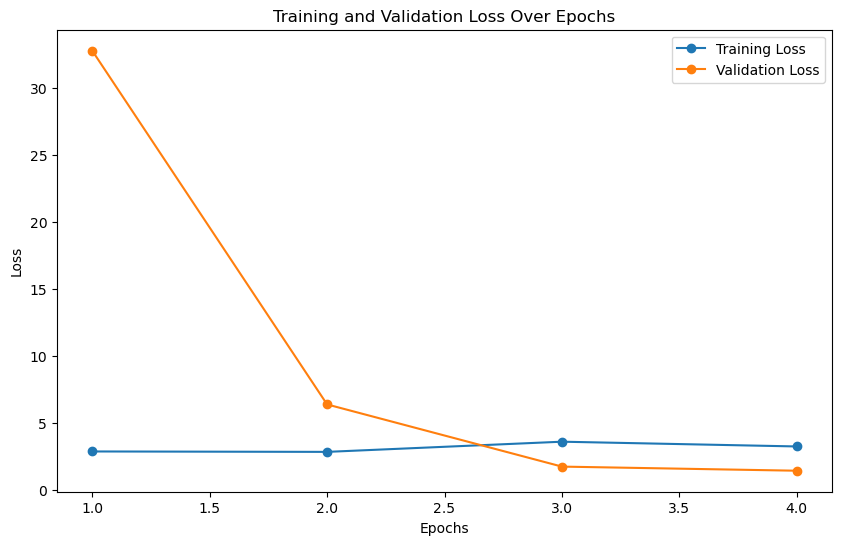

In [8]:
# create training/validation plot
epochs = range(1, epoch+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.show()
plt.savefig(os.path.join(root_path, 'plot.png'))

In [9]:
pred_labels = pred.detach().numpy()
pred_binary = np.where(pred_labels>=0.01, 1,0)
y_scores = test_data.y.detach().numpy()


accuracy = balanced_accuracy_score(y_scores, pred_binary, sample_weight=sample_weight)
f1_micro = f1_score(y_scores, pred_binary,average='micro')
f1_macro = f1_score(y_scores, pred_binary,average='macro')
roc_auc = roc_auc_score(y_scores, pred_binary)
recall = recall_score(y_scores, pred_binary)
precision = precision_score(y_scores, pred_binary)

print('accuracy: ' + str(accuracy))
print('f1_micro: ' + str(f1_micro))
print('f1_macro: ' + str(f1_macro))
print('roc_auc: ' + str(roc_auc))
print('recall: ' + str(recall))
print('precision: ' + str(precision))



accuracy: 0.5
f1_micro: 0.024009109943797527
f1_macro: 0.023446187842132826
roc_auc: 0.5
recall: 1.0
precision: 0.024009109943797523
